# Importing Libraries

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [5]:
train_file = "/content/drive/MyDrive/dataset/Digits/train.csv"
test_file = "/content/drive/MyDrive/dataset/Digits/test.csv"
output_file = "/content/drive/MyDrive/dataset/Digits/submission.csv"


# Load the data
As always, we split the data into a training set and a validation set, so that we can evaluate the performance of our model.

In [6]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(
    raw_data[:,1:], raw_data[:,0], test_size=0.1)

Each data point consists of 784 values. A fully connected net just treats all these values the same, but a CNN treats it as a 28x28 square. Thes two graphs explain the difference: It's easy to understand why a CNN can get better results.

Text(0.5, 1.0, '28x28 data')

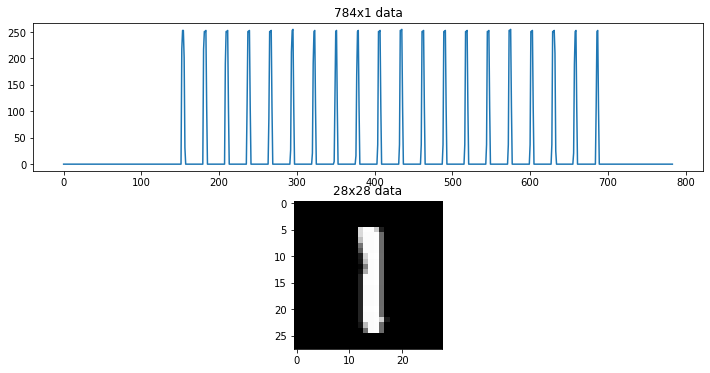

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

We now reshape all data this way. Keras wants an extra dimension in the end, for channels. If this had been RGB images, there would have been 3 channels, but as MNIST is gray scale it only uses one.

In [8]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

It would be possible to train the net on the original data, with pixel values 0 to 255. If we use the standard initialization methods for weights, however, data between 0 and 1 should make the net converge faster

In [9]:
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

The labels were given as integers between 0 and 9. We need to convert these to one-hot encoding, i.e. a 10x1 array with one 1 and nine 0:s, with the position of the 1 showing us the value. See the example, with the position of the 1 showing the correct value for the digit in the graph above.

In [10]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


# Train the model

In [11]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [12]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=["accuracy"])

In [14]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

Another important method to improve generalization is augmentation. This means generating more training data by randomly perturbing the images. If done in the right way, it can force the net to only learn translation-invariant features. If you train this model over hundreds of epochs, augmentation will definitely improve your performance. Here in the Kernel, we will only look at each image 4-5 times, so the difference is smaller. We use a Keras function for augmentation.

In [15]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=20, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
500/500 - 37s - loss: 0.8300 - accuracy: 0.7320 - val_loss: 0.3751 - val_accuracy: 0.8725 - lr: 0.0010 - 37s/epoch - 74ms/step
Epoch 2/20
500/500 - 6s - loss: 0.3183 - accuracy: 0.9028 - val_loss: 0.1371 - val_accuracy: 0.9525 - lr: 9.0000e-04 - 6s/epoch - 12ms/step
Epoch 3/20
500/500 - 6s - loss: 0.2523 - accuracy: 0.9222 - val_loss: 0.0844 - val_accuracy: 0.9750 - lr: 8.1000e-04 - 6s/epoch - 12ms/step
Epoch 4/20
500/500 - 6s - loss: 0.1974 - accuracy: 0.9396 - val_loss: 0.0719 - val_accuracy: 0.9700 - lr: 7.2900e-04 - 6s/epoch - 13ms/step
Epoch 5/20
500/500 - 6s - loss: 0.1740 - accuracy: 0.9481 - val_loss: 0.0528 - val_accuracy: 0.9800 - lr: 6.5610e-04 - 6s/epoch - 12ms/step
Epoch 6/20
500/500 - 6s - loss: 0.1477 - accuracy: 0.9557 - val_loss: 0.0493 - val_accuracy: 0.9750 - lr: 5.9049e-04 - 6s/epoch - 12ms/step
Epoch 7/20
500/500 - 6s - loss: 0.1396 - accuracy: 0.9607 - val_loss: 0.0393 - val_accuracy: 0.9875 - lr: 5.3144e-04 - 6s/epoch - 12ms/step
Epoch 8/20
500/500 - 6

In [16]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0329, final accuracy: 0.9919


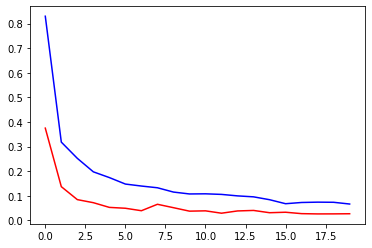

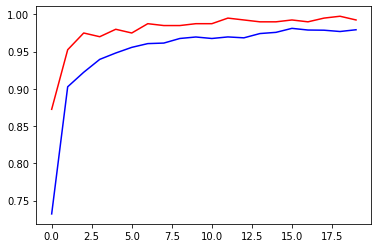

In [19]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.show()

In [20]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[431   0   0   0   1   1   0   0   1   0]
 [  0 462   0   0   0   0   0   1   0   1]
 [  1   0 390   1   0   0   0   0   0   1]
 [  0   0   0 437   0   1   0   0   1   0]
 [  0   2   1   0 399   0   0   1   0   2]
 [  0   0   0   0   0 347   1   0   0   0]
 [  0   0   0   0   0   0 409   0   0   0]
 [  0   3   2   0   0   0   0 441   0   6]
 [  0   0   1   1   0   2   1   0 402   0]
 [  0   0   0   0   1   0   0   0   0 448]]


In [21]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [22]:
y_hat = model.predict(x_test, batch_size=64)

In [23]:
y_pred = np.argmax(y_hat,axis=1)

In [24]:
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))